In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import quick_eda

In [3]:
df_train = pd.read_csv('../data/playground-series-s5e5/train.csv')
quick_eda(df_train)

Shape: 750000 rows and 9 columns
Duplicates check: 0 duplicate rows found

Sample data:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


Data types and missing count:


,dtype,non_missing,missing,missing_pct
id,int64,750000,0,0.0
Sex,object,750000,0,0.0
Age,int64,750000,0,0.0
Height,float64,750000,0,0.0
Weight,float64,750000,0,0.0
Duration,float64,750000,0,0.0
Heart_Rate,float64,750000,0,0.0
Body_Temp,float64,750000,0,0.0
Calories,float64,750000,0,0.0


Summary:


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.00,750000.00,750000.00,750000.00,750000.00,750000.00,750000.00,750000.00
mean,374999.50,41.42,174.70,75.15,15.42,95.48,40.04,88.28
std,216506.50,15.18,12.82,13.98,8.35,9.45,0.78,62.40
min,0.00,20.00,126.00,36.00,1.00,67.00,37.10,1.00
25%,187499.75,28.00,164.00,63.00,8.00,88.00,39.60,34.00
50%,374999.50,40.00,174.00,74.00,15.00,95.00,40.30,77.00
75%,562499.25,52.00,185.00,87.00,23.00,103.00,40.70,136.00
max,749999.00,79.00,222.00,132.00,30.00,128.00,41.50,314.00


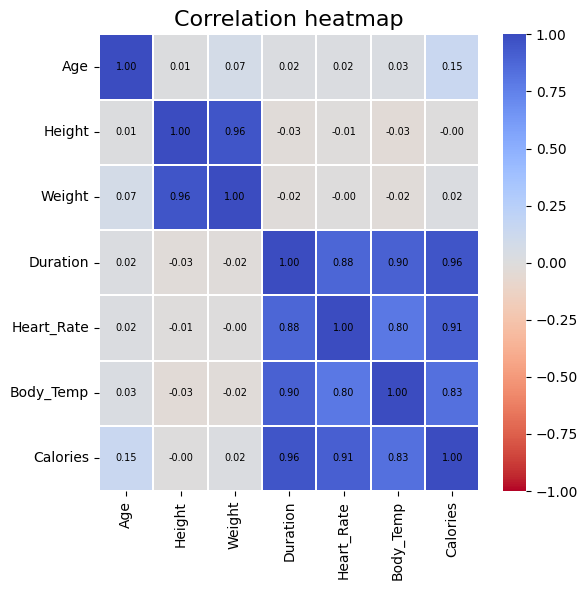

In [4]:
plt.figure(figsize=(6, 6))

sns.heatmap(
    df_train.drop(columns='id').corr(numeric_only=True),
    cmap='coolwarm_r',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.01,
    annot=True,
    annot_kws={'fontsize':7, 'color': 'black'},
    fmt='.2f'
)

plt.title('Correlation heatmap', fontsize=16)
plt.tight_layout()
plt.show()

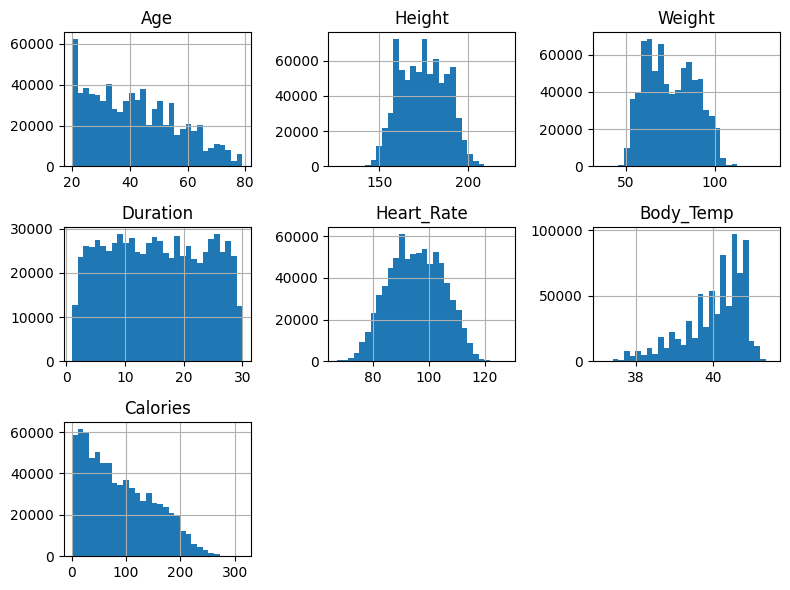

In [5]:
df_train.drop(columns='id').hist(figsize=(8, 6), bins=30)
plt.tight_layout()
plt.show()

In [6]:
df_train['Age_sqr'] = df_train['Age'] ** 2
df_train['Sex_male'] = (df_train['Sex'] == 'male').astype(int)
df_train['Duration_Male'] = df_train['Duration'] * df_train['Sex_male']
df_train['log_Duration'] = np.log1p(df_train['Duration'])
df_train['log_Heart_Rate'] = np.log1p(df_train['Heart_Rate'])
df_train['Duration_HeartR'] = df_train['Duration'] * df_train['Heart_Rate']
df_train['Duration_BodyT'] = df_train['Duration'] * df_train['Body_Temp']
df_train['HeartR_BodyT'] = df_train['Heart_Rate'] * df_train['Body_Temp']
df_train['BMI'] = df_train['Weight'] / (df_train['Height'] / 100) ** 2
df_train['BMI_Duration'] = df_train['BMI'] * df_train['Duration']
df_train['BMI_Heart_Rate'] = df_train['BMI'] * df_train['Heart_Rate']
df_train['Temp_dev'] = df_train['Body_Temp'] - 37.0
df_train['Heart_Age_ratio'] = df_train['Heart_Rate'] / df_train['Age']

In [7]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb

In [8]:
target = 'Calories'
features = [col for col in df_train.columns if col not in ['id', target, 'Sex']]

x = df_train[features]
y = df_train[target]

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.35, random_state=42)

y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

print(f'Treino: {x_train.shape}')
print(f'Validação: {x_valid.shape}')

Treino: (487500, 19)
Validação: (262500, 19)


In [9]:
scaler = StandardScaler()

k_features = 15
feature_selector = SelectKBest(score_func=f_regression, k=k_features)

lgbm = lgb.LGBMRegressor(random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', feature_selector),
    ('model', lgbm)
])

In [ ]:
param_distributions = {
    'selector__k': [10, 12, 15, 18, 'all'],
    'model__n_estimators': [100, 200, 300, 500, 700],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__num_leaves': [15, 31, 50, 70],
    'model__max_depth': [-1, 5, 10, 15],
    'model__reg_alpha': [0, 0.01, 0.1, 0.5],
    'model__reg_lambda': [0, 0.01, 0.1, 0.5],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0], 
    'model__subsample': [0.7, 0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [11]:
random_search.fit(x_train, y_train_log)

print('-' * 30)
print(f'Melhores parâmetros encontrados:')
print(random_search.best_params_)
print('-' * 30)
print(f'Melhor score (neg MSE) na validação cruzada: {random_search.best_score_:.4f}')
print('-' * 30)

best_pipeline = random_search.best_estimator_

Iniciando Randomized Search CV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 487500, number of used features: 18
[LightGBM] [Info] Start training from score 4.141349
------------------------------
Melhores parâmetros encontrados:
{'selector__k': 18, 'model__subsample': 1.0, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.5, 'model__num_leaves': 31, 'model__n_estimators': 300, 'model__max_depth': -1, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.9}
Melhor score (neg MSE) na validação cruzada: -0.0037
------------------------------


In [12]:
y_pred_log = best_pipeline.predict(x_valid)
y_pred = np.expm1(y_pred_log)
score = root_mean_squared_log_error(y_valid, y_pred)

print('-' * 30)
print(f'RMSLE (validação): {score:.5f}')
print('-' * 30)

c:\Users\vgprinciotti\Desktop\projects\kaggle\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


------------------------------
RMSLE (validação): 0.06118
------------------------------


In [13]:
best_pipeline.fit(x, np.log1p(y))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 18
[LightGBM] [Info] Start training from score 4.141144


Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=18,
                             score_func=<function f_regression at 0x0000020E93C463E0>)),
                ('model',
                 LGBMRegressor(colsample_bytree=0.9, n_estimators=300,
                               random_state=42, reg_alpha=0.5,
                               reg_lambda=0.1))])

In [14]:
selector_estimator = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=100)
feature_selector = SelectFromModel(
    selector_estimator,
    max_features=18,
    threshold=-np.inf
)

xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

new_pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', feature_selector),
    ('model', xgb_model)
])

In [17]:
param_grid = {
    'model__n_estimators': [250, 300, 350],
    'model__learning_rate': [0.07, 0.1, 0.13],
    'model__max_depth': [5, 6, 7],
    'model__subsample': [1.0],
    'model__colsample_bytree': [0.9],
    'model__reg_alpha': [0.5],
    'model__reg_lambda': [0.1]
}

grid_search = GridSearchCV(
    estimator=new_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [18]:
grid_search.fit(x_train, y_train_log)

print('-' * 30)
print(f'Melhores parâmetros encontrados:')
print(grid_search.best_params_)
print('-' * 30)
print(f'Melhor score (neg MSE) na validação cruzada: {grid_search.best_score_:.4f}')
print('-' * 30)

best_pipeline_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
------------------------------
Melhores parâmetros encontrados:
{'model__colsample_bytree': 0.9, 'model__learning_rate': 0.07, 'model__max_depth': 7, 'model__n_estimators': 350, 'model__reg_alpha': 0.5, 'model__reg_lambda': 0.1, 'model__subsample': 1.0}
------------------------------
Melhor score (neg MSE) na validação cruzada: -0.0037
------------------------------


In [19]:
y_pred_log_xgb = best_pipeline_xgb.predict(x_valid)
y_pred_xgb = np.expm1(y_pred_log_xgb)
score_xgb = root_mean_squared_log_error(y_valid, y_pred_xgb)

print('-' * 30)
print(f'RMSLE (validação): {score_xgb:.5f}')
print('-' * 30)

------------------------------
RMSLE (validação): 0.06080
------------------------------


In [20]:
best_pipeline_xgb.fit(x, np.log1p(y))

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        feature_weights=None,
                                                        gamma=None,
                                                        grow_policy=...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.07,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=350, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [21]:
df_test = pd.read_csv('../data/playground-series-s5e5/test.csv')
quick_eda(df_test)

Shape: 250000 rows and 8 columns
Duplicates check: 0 duplicate rows found

Sample data:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


Data types and missing count:


,dtype,non_missing,missing,missing_pct
id,int64,250000,0,0.0
Sex,object,250000,0,0.0
Age,int64,250000,0,0.0
Height,float64,250000,0,0.0
Weight,float64,250000,0,0.0
Duration,float64,250000,0,0.0
Heart_Rate,float64,250000,0,0.0
Body_Temp,float64,250000,0,0.0


Summary:


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,250000.00,250000.00,250000.00,250000.00,250000.00,250000.00,250000.00
mean,874999.50,41.45,174.73,75.15,15.42,95.48,40.04
std,72168.93,15.18,12.82,13.98,8.35,9.45,0.78
min,750000.00,20.00,127.00,39.00,1.00,67.00,37.10
25%,812499.75,28.00,164.00,63.00,8.00,88.00,39.60
50%,874999.50,40.00,174.00,74.00,15.00,95.00,40.30
75%,937499.25,52.00,185.00,87.00,23.00,103.00,40.60
max,999999.00,79.00,219.00,126.00,30.00,128.00,41.50


In [22]:
df_test['Age_sqr'] = df_test['Age'] ** 2
df_test['Sex_male'] = (df_test['Sex'] == 'male').astype(int)
df_test['Duration_Male'] = df_test['Duration'] * df_test['Sex_male']
df_test['log_Duration'] = np.log1p(df_test['Duration'])
df_test['log_Heart_Rate'] = np.log1p(df_test['Heart_Rate'])
df_test['Duration_HeartR'] = df_test['Duration'] * df_test['Heart_Rate']
df_test['Duration_BodyT'] = df_test['Duration'] * df_test['Body_Temp']
df_test['HeartR_BodyT'] = df_test['Heart_Rate'] * df_test['Body_Temp']
df_test['BMI'] = df_test['Weight'] / (df_test['Height'] / 100) ** 2
df_test['BMI_Duration'] = df_test['BMI'] * df_test['Duration']
df_test['BMI_Heart_Rate'] = df_test['BMI'] * df_test['Heart_Rate']
df_test['Temp_dev'] = df_test['Body_Temp'] - 37.0
df_test['Heart_Age_ratio'] = df_test['Heart_Rate'] / df_test['Age']

In [23]:
y_test_log = best_pipeline_xgb.predict(df_test[features])
y_test = np.expm1(y_test_log)

submission = pd.read_csv('../data/playground-series-s5e5/sample_submission.csv')
submission['Calories'] = y_test
submission.to_csv('../outputs/playground-series-s5e5/submission.csv', index=False)
submission.head()

,id,Calories
0,750000,27.269987
1,750001,108.532242
2,750002,86.693550
3,750003,126.328918
4,750004,75.996689
